# Exploratory Data Analysis: Risk Analytics

This notebook aims to validate the quality and coherence of the synthetic dataset generated for the fraud detection project. Before training any model, we must confirm that behavioral patterns (fixed expenses, seasonality, customer profiles) and fraud patterns (velocity and magnitude attacks) are correctly reflected in the data. 

## 1. Configuration and Data Loading

We import necessary libraries and load the `transactions_simulated.csv` dataset, making sure each column is interpreted as the correct dtype.  

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path = os.path.join("..","data", "transactions_simulated.csv")
df = pd.read_csv(file_path, 
                 dtype={'Customer_Profile': 'category', 
                        'Location': 'category', 
                        'Category': 'category',
                        'Is_Fraud': 'int8',
                        'Is_Fixed': 'int8'},
                 parse_dates=['Timestamp'])

# Add an additional column to classify transactions between Legitimate, Magnitude attacks and Velocity attacks.
df['TXN_Type'] = df.apply(
    (lambda x: 'Velocity' if 'VEL' in x['Terminal_ID'] and x['Is_Fraud'] == 1 
               else 'Magnitude' if 'BIG' in x['Terminal_ID'] and x['Is_Fraud'] == 1
               else 'Legitimate'), axis=1)
df['TXN_Type'] = df['TXN_Type'].astype('category')

print(df.head())

  Transaction_ID Customer_ID Customer_Profile Customer_Home  Amount  \
0      FRD-36877    CUS-0697          Unknown        Malaga   11.36   
1      FRD-38579    CUS-0859          Unknown     Barcelona    7.55   
2      FRD-38580    CUS-0859          Unknown     Barcelona   22.26   
3      FRD-36878    CUS-0697          Unknown        Malaga    5.94   
4      FRD-38581    CUS-0859          Unknown     Barcelona   11.06   

            Timestamp   Terminal_ID Category  Location  Is_Fixed  Is_Fraud  \
0 2026-01-01 02:03:00  TERM_VEL_055   Retail    Malaga         0         1   
1 2026-01-01 02:03:00  TERM_VEL_383   Retail  Zaragoza         0         1   
2 2026-01-01 02:04:00  TERM_VEL_383   Retail  Zaragoza         0         1   
3 2026-01-01 02:04:00  TERM_VEL_055   Retail    Malaga         0         1   
4 2026-01-01 02:05:00  TERM_VEL_383   Retail  Zaragoza         0         1   

   TXN_Type  
0  Velocity  
1  Velocity  
2  Velocity  
3  Velocity  
4  Velocity  


We have all the columns we wanted. The content seems correct.

In [50]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39229 entries, 0 to 39228
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Transaction_ID    39229 non-null  object        
 1   Customer_ID       39229 non-null  object        
 2   Customer_Profile  39229 non-null  category      
 3   Customer_Home     39229 non-null  object        
 4   Amount            39229 non-null  float64       
 5   Timestamp         39229 non-null  datetime64[ns]
 6   Terminal_ID       39229 non-null  object        
 7   Category          39229 non-null  category      
 8   Location          39229 non-null  category      
 9   Is_Fixed          39229 non-null  int8          
 10  Is_Fraud          39229 non-null  int8          
 11  TXN_Type          39229 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(1), int8(2), object(4)
memory usage: 2.0+ MB
None


We generated 39229 entries and none are null, confiming a clean data generation process. The dtypes are also correct.

In [51]:
print(df.describe())

             Amount                      Timestamp     Is_Fixed      Is_Fraud
count  39229.000000                          39229  39229.00000  39229.000000
mean     182.649879  2026-01-15 11:52:24.528282112      0.04099      0.066813
min        2.120000            2026-01-01 02:03:00      0.00000      0.000000
25%       47.520000  2026-01-07 19:57:57.916052992      0.00000      0.000000
50%       75.390000  2026-01-15 10:58:01.006803968      0.00000      0.000000
75%      130.110000     2026-01-23 08:37:39.145312      0.00000      0.000000
max    19661.540000            2026-01-31 07:59:00      1.00000      1.000000
std      462.666394                            NaN      0.19827      0.249701


The generated dataset consists of 39,229 records spanning the full month of January 2026. Financial metrics reveal a mean transaction amount of approximately 182.65€ and a high standard deviation of 462.67€ reflecting a heavy-tailed distribution consistent with the Log-Normal model, while the wide range, from a minimum of 2.12€ to a maximum of 19,661€, validates the successful injection of magnitude outliers. Fixed recurring expenses account for 4.1% of the volume. We will cover fraud indicators in the next section.

## 2. Fraud Analysis

In fraud detection, we expect a strong class imbalance. Most transactions are legitimate. We verify the fraud ratio to confirm it is within a realistic range. If it were very high (>5%) or very low (<0.01%), we would face issues training the model later.


In [52]:
fraud_counts = df['Is_Fraud'].value_counts()   # Count of fraud vs non-fraud transactions
fraud_rate_tx = (df['Is_Fraud'].mean()) * 100  # Percentage of fraud transactions
    
print(f"Global Fraud Ratio (By Transaction): {fraud_rate_tx:.2f}%")
print(f"Total Fraud Transactions: {df['Is_Fraud'].sum()}")

Global Fraud Ratio (By Transaction): 6.68%
Total Fraud Transactions: 2621


This fraud ratio and volume may seem troublesome, but the reason there is 2621 fraud cases is beacause each individual operation of the velocity attacks counts as one. In reality, we should have the 500 anomalies if grouped correctly.

In [53]:
fraud_counts = df[df['Is_Fraud'] == 1].nunique()['Terminal_ID'] # Unique fraud terminals
fraud_rate = fraud_counts / (df.shape[0] - 2121 ) * 100 # Adjusted rate taking into account velocity attacks as one transaction

print(f"Global Fraud Ratio (By Transaction): {fraud_rate:.2f}%")
print(f"Total Frauds: {fraud_counts}")

Global Fraud Ratio (By Transaction): 1.35%
Total Frauds: 500


Once we analyzed each attack individually, we obtain some more reasonable numbers. A bit less than 1.5% we aimed for due to the generation of fixed expenses being independent from discretionary ones.

### 2.1. Attack Typology

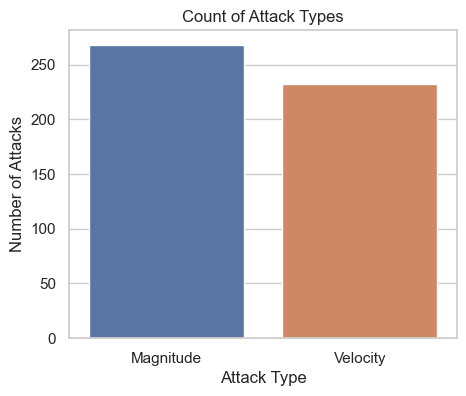

In [54]:
# Visual style configuration for plots
sns.set_theme(style="whitegrid", context="notebook", palette="deep")

# Create a collapsed dataframe for fraud analysis, each attack is grouped into a single row
attacks_collapsed = df[df['Is_Fraud'] == 1].groupby('Terminal_ID').agg(
        Attack_Type=('TXN_Type', 'first'),      # 0 if it is a velocity attack, 1 if it is a magnitude attack
        Total_Attempts=('Transaction_ID', 'count'),       
        Total_Stolen=('Amount', 'sum'),                   
        Start_Time=('Timestamp', 'min'),                 
        End_Time=('Timestamp', 'max'),               
        Victim_ID=('Customer_ID', 'first')       
    ).reset_index()
attacks_collapsed['Attack_Type'] = attacks_collapsed['Attack_Type'].cat.remove_categories(['Legitimate'])

# Plotting the distribution of attack types
fig, ax_count = plt.subplots(figsize=(5, 4))
sns.countplot(x='Attack_Type', data=attacks_collapsed, ax = ax_count, hue='Attack_Type')
ax_count.set_title('Count of Attack Types')
ax_count.set_ylabel('Number of Attacks')
ax_count.set_xlabel('Attack Type')

plt.show()

We observe a roughly equal distribution between Velocity and Magnitude attack events.

### 2.2. Attack Timing

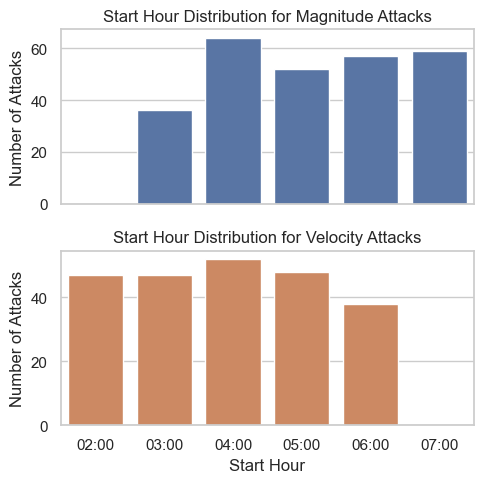

In [55]:
# Plotting the distribution of start hours for each attack type
attacks_collapsed['Start_Hour'] = attacks_collapsed['Start_Time'].dt.hour         # Feature engineering for start hour

h_order = [h for h in range(2,8)] # Hours from 1 to 8 AM to create the x-axis labels
h_label = [f"{h:02d}:00" for h in h_order]

# Plotting the distribution of hours for magnitude attack
fig, (ax_hmag , ax_hvel) = plt.subplots(2,1, figsize=(5, 5), sharex=True)
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Magnitude']['Start_Hour'], ax=ax_hmag, order=h_order, color='#4c72b0')
ax_hmag.set_title('Start Hour Distribution for Magnitude Attacks')
ax_hmag.set_xlabel('Start Hour')
ax_hmag.set_ylabel('Number of Attacks')

# Plotting the distribution of hours for velocity attack
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity']['Start_Hour'],  ax=ax_hvel, order=h_order, color='#dd8452')
ax_hvel.set_title('Start Hour Distribution for Velocity Attacks')
ax_hvel.set_xlabel('Start Hour')
ax_hvel.set_xticks(range(len(h_order)))
ax_hvel.set_xticklabels(h_label)
ax_hvel.set_ylabel('Number of Attacks')
plt.tight_layout()

plt.show()

Fraud occurs exclusively during low-traffic hours (02:00 – 07:00):

- Magnitude Attacks: 03:00 AM – 07:00 AM with a uniform distribution.
- Velocity Attacks: 02:00 AM – 06:00 AM with a uniform distribution.

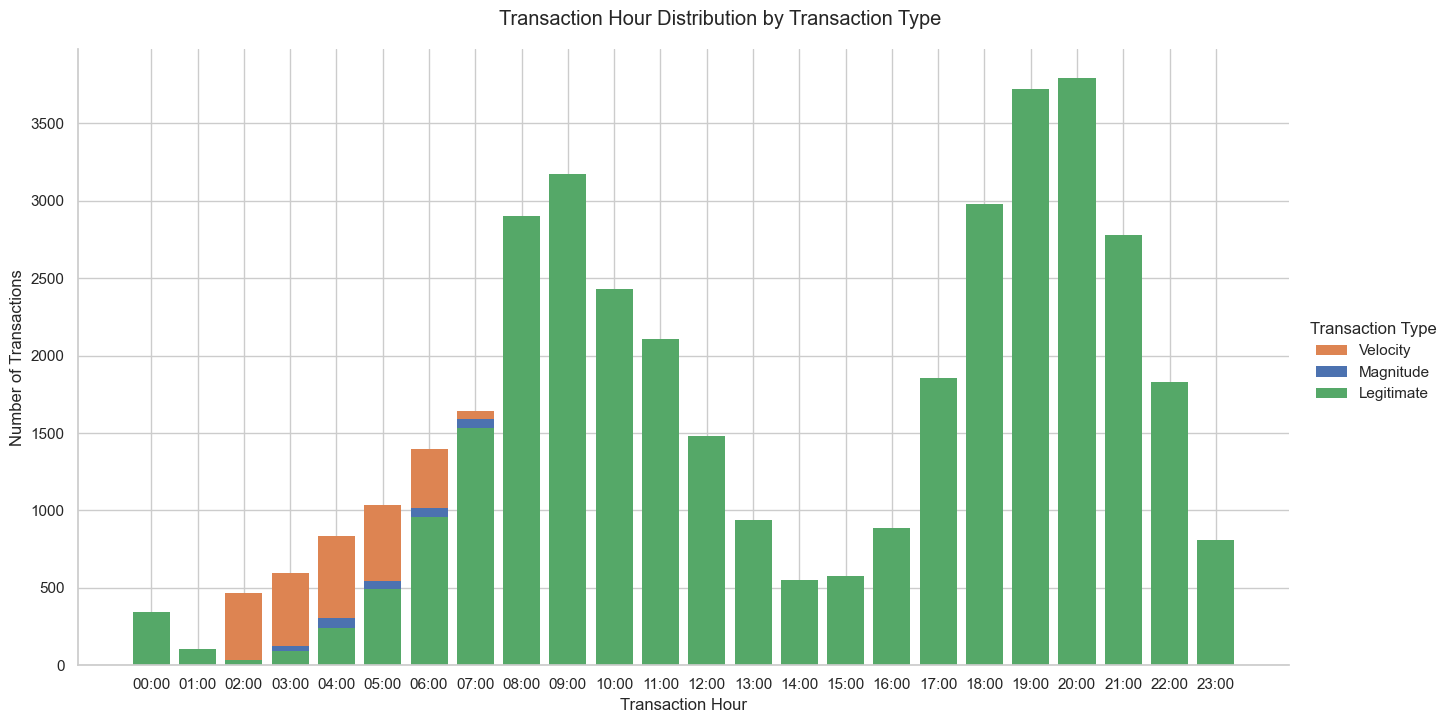

In [56]:
# Plotting the distribution of transaction hour for non-fraud transactions stacked with fraud transactions
df['Hour'] = df['Timestamp'].dt.hour           # Feature engineering for transaction hour

g = sns.displot(
        data=df,
        x='Hour',
        hue='TXN_Type',
        multiple='stack',
        palette={'Legitimate': '#55a868', 'Velocity': '#dd8452', 'Magnitude': '#4c72b0'},
        hue_order=['Velocity', 'Magnitude', 'Legitimate'],
        discrete=True, shrink=0.8, height=7, aspect=1.9, alpha=1.0, linewidth=0      
    )

g.set_axis_labels('Transaction Hour', 'Number of Transactions')
g.fig.suptitle('Transaction Hour Distribution by Transaction Type', y=1.03)
g.set(xticks=range(0, 24))
g.ax.set_xticklabels([f"{h:02d}:00" for h in range(0, 24)])
g.legend.set_title('Transaction Type')

os.makedirs('../images', exist_ok=True)
plt.savefig('../images/transaction_hour.png', dpi=300, bbox_inches='tight')

plt.show()

The stacked histogram above provides a critical validation of our simulation engine's temporal logic:

1. Bimodal Distribution:

    The Legitimate (Green) transactions  clearly exhibit the intended double-peak structure, reflecting real-world human activity.

    - Morning Peak (~10:00 AM): Corresponds to daily commutes and opening business hours.
    - Evening Peak (~08:00 PM): Corresponds to leisure activities and after-work shopping.
    - Night Valley: Activity drops significantly during sleeping hours (23:00 - 06:00 AM), creating a natural low-volume window.

2. Fraud Isolation:

    While legitimate traffic follows a bimodal distribution, Velocity (Orange) and Magnitude (Blue) fraud attempts are distinctly concentrated in the low-volume overnight window. This visual separation confirms that our anomaly injection logic successfully targeted the "vulnerable hours" where anomalies stand out against the background noise.

### 2.3. Day of the week

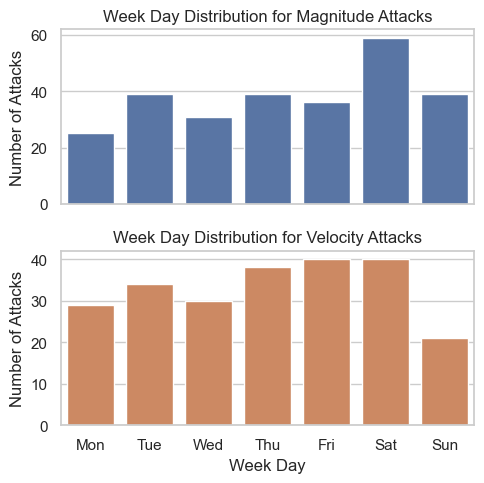

In [57]:
# Plotting the distribution of week days for each attack type
attacks_collapsed['Week_Day'] = attacks_collapsed['Start_Time'].dt.day_name()     # Feature engineering for week day of the attack

w_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']  # Week day order for x-axis
w_label = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

fig, (ax_wmag , ax_wvel) = plt.subplots(2,1, figsize=(5, 5), sharex=True)

# Plotting the distribution of week days for magnitude attack
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Magnitude']['Week_Day'], ax=ax_wmag, order=w_order, color='#4c72b0')
ax_wmag.set_title('Week Day Distribution for Magnitude Attacks')
ax_wmag.set_xlabel('Week Day')
ax_wmag.set_ylabel('Number of Attacks')

# Plotting the distribution of week days for velocity attack
sns.countplot(x = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity']['Week_Day'],  ax=ax_wvel, order=w_order, color='#dd8452')
ax_wvel.set_title('Week Day Distribution for Velocity Attacks')
ax_wvel.set_xlabel('Week Day')
ax_wvel.set_xticks(range(len(w_label)))
ax_wvel.set_xticklabels(w_label)
ax_wvel.set_ylabel('Number of Attacks')
plt.tight_layout()

plt.show()

Fraudulent transactions (both Velocity and Magnitude) exhibit uniform-like distribution across the week. Maybe Magnitude attacks happen more often on Saturdays and Velocity attacks are less likely to happen on Sundays. Next up we will test the statistical significance of this affirmation.

In [58]:
from scipy.stats import chisquare

# Function to perform Chi-Squared test for uniformity on a categorical column
def test_uniformity(df, column_name):
    """
    Performs a Chi-Squared test to verify uniformity in a categorical column.
    """
    print(f'Uniformity Test (Chi-Squared) for: {column_name}')
    
    observed_counts = df[column_name].value_counts().sort_index()
    
    total_events = observed_counts.sum()
    n_categories = len(observed_counts)
    expected_count = total_events / n_categories

    expected_counts = [expected_count] * n_categories

    chi2_stat, p_value = chisquare(f_obs=observed_counts, f_exp=expected_counts)
    
    print(f'Chi2 Statistic: {chi2_stat:.4f}')
    print(f'P-Value: {p_value:.4f}')
    
    alpha = 0.05
    if p_value < alpha:
        print('Result: Null hypothesis rejected.')
        print(f'Conclusion: The distribution of {column_name} is NOT uniform (There is seasonality/patterns).')
    else:
        print('Result: Cannot reject the null hypothesis.')
        print(f'Conclusion: The distribution of {column_name} is compatible with being UNIFORM.')

# Testing uniformity for 'Week_Day' column for both attack types
print("\nTesting Uniformity for Magnitude Attacks:")
test_uniformity(attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Magnitude'], 'Week_Day')

print("\nTesting Uniformity for Velocity Attacks:")
test_uniformity(attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity'], 'Week_Day')


Testing Uniformity for Magnitude Attacks:
Uniformity Test (Chi-Squared) for: Week_Day
Chi2 Statistic: 17.3806
P-Value: 0.0080
Result: Null hypothesis rejected.
Conclusion: The distribution of Week_Day is NOT uniform (There is seasonality/patterns).

Testing Uniformity for Velocity Attacks:
Uniformity Test (Chi-Squared) for: Week_Day
Chi2 Statistic: 8.8362
P-Value: 0.1830
Result: Cannot reject the null hypothesis.
Conclusion: The distribution of Week_Day is compatible with being UNIFORM.


Unexpectedly, the Chi-Squared test for Magnitude Fraud rejected the null hypothesis of uniformity ($p < 0.05$), despite the generation logic using a uniform random selection.

This phenomenon is likely due to sample size volatility. Since Magnitude Fraud has a bit over 250 transactions registered, Type I Error or simply lack of convergence odds are higher and this result is possible.

On the other hand, Velocity attacks passed the test, confirming a statistically uniform distribution across the days of the week. This lack of seasonality may serve as a feature for our ML models.

If we were analyzing this dataset as an external Data Scientist without prior knowledge of the generation script, these statistical tests would have leaded me to the following insights regarding fraud patterns.

1.  Detecting Automation via Uniformity:
    The fact that Velocity Fraud passed the Chi-Squared test for uniformity ($p > 0.05$) would be my primary indicator of bot activity. In a real-world investigation, observing a high-frequency transaction pattern that completely ignores weekly human cycles (weekends, workdays) is a strong indicator of automated scripts.

2.  Profiling "Campaigns" via Seasonality:
    Conversely, the rejection of uniformity in Magnitude Fraud ($p < 0.05$) would lead me to classify these events as seasonal. In cybersecurity, high-value attacks are rarely constant, they occur in bursts when a vulnerability is exploited.

It is crucial to interpret these results with transparency. While the insights derived from the statistical tests make perfect sense from an analytical perspective, classifying Velocity attacks as "bots" and Magnitude attacks as "campaigns", we possess the ground truth of the generation logic and these insights are the result of a statistical coincidence.

This observation serves as a powerful reminder for Risk Analysts. While statistical tests are essential tools for inference, they can sometimes over-interpret noise as a signal, especially when analyzing rare events (minority classes). In a real-world scenario without access to the "source code", we might have incorrectly concluded that there was an intentional temporal pattern where there was only chance.

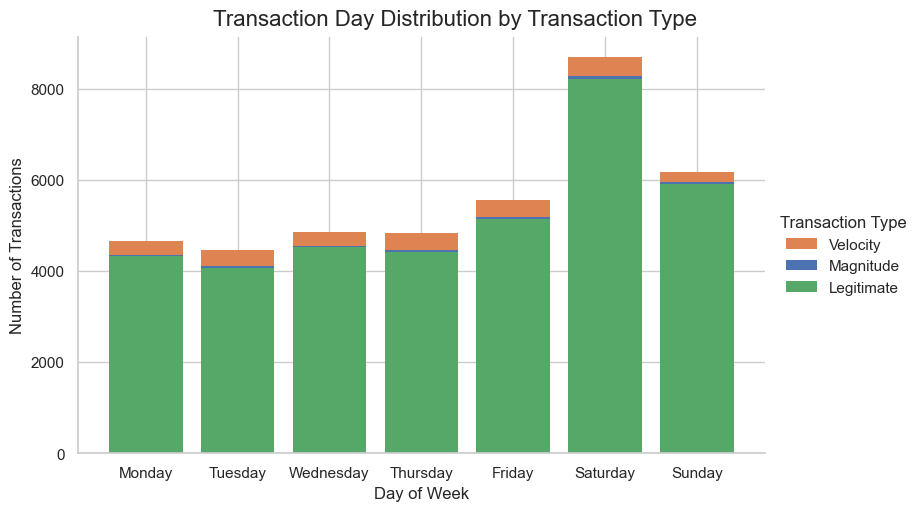

In [59]:
# Plotting the distribution of transaction hour for non-fraud transactions stacked with fraud transactions
df['Week_Day'] = df['Timestamp'].dt.day_name()       # Feature engineering for transaction week day
df['Week_Day'] = pd.Categorical(df['Week_Day'], categories=w_order, ordered=True)

g = sns.displot(
        data=df,
        x='Week_Day',
        hue='TXN_Type',
        multiple='stack',
        palette={'Legitimate': '#55a868', 'Velocity': '#dd8452', 'Magnitude': '#4c72b0'},
        hue_order=['Velocity', 'Magnitude', 'Legitimate'],
        discrete=True, shrink=0.8, height=5, aspect=1.6, alpha=1.0, linewidth=0
    )

g.set_axis_labels('Day of Week', 'Number of Transactions')
g.fig.suptitle('Transaction Day Distribution by Transaction Type', y=1.02, fontsize=16)
    
g.legend.set_title('Transaction Type')

plt.show()

Given the previous coincidence in the Magnitude Chisquare test, we will perform the test on the non-fraudulent transactions before giving any insights.

In [60]:
# Testing uniformity for 'Week_Day' column for legitimate transactions

print("\nTesting Uniformity for Legitimate transactions:")
test_uniformity(df[df['TXN_Type'] == 'Legitimate'], 'Week_Day')


Testing Uniformity for Legitimate transactions:
Uniformity Test (Chi-Squared) for: Week_Day
Chi2 Statistic: 2431.8150
P-Value: 0.0000
Result: Null hypothesis rejected.
Conclusion: The distribution of Week_Day is NOT uniform (There is seasonality/patterns).


The tests confirms the logic we used generating the data.

The distribution of transactions across the days of the week further validates our behavioral simulation, the volume of legitimate transactions remains relatively uniform during weekdays (Monday to Thursday), reflecting routine daily spending.

A significant surge occurs on Friday and weekends, with activity peaking on Saturday and remaining high on Sunday. This aligns with the increased weights assigned to discretionary categories like Leisure and Retail during free time.

### 2.4. Amount Analysis

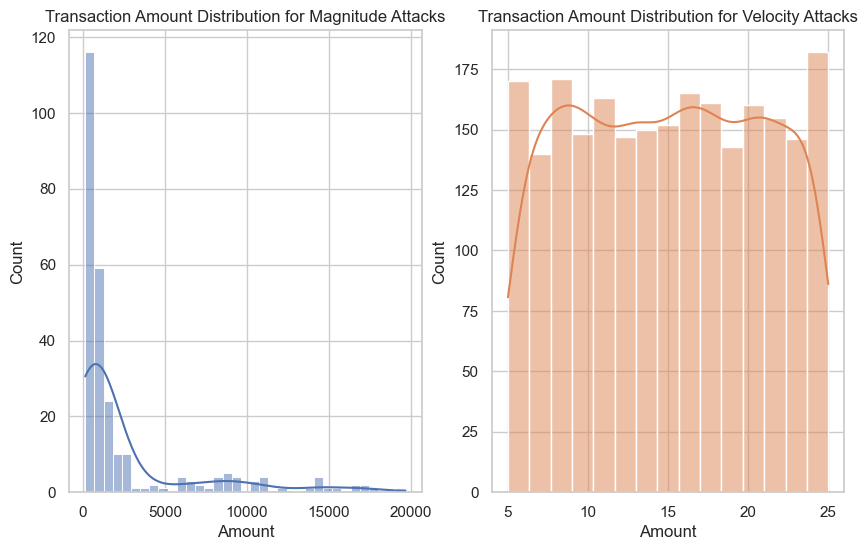

In [61]:
# Visualize the distribution of transaction amounts by TXN_Type
fig, ax_hisam = plt.subplots(1,2,figsize=(10, 6))

sns.histplot(data=df[df['TXN_Type'] == 'Magnitude'], x='Amount', bins=35, kde=True, color='#4c72b0', ax=ax_hisam[0])
ax_hisam[0].set_title('Transaction Amount Distribution for Magnitude Attacks')

sns.histplot(data=df[df['TXN_Type'] == 'Velocity'], x='Amount', bins=15, kde=True, color='#dd8452', ax=ax_hisam[1])
ax_hisam[1].set_title('Transaction Amount Distribution for Velocity Attacks')

plt.show()

This confirms our generation logic: Velocity follows a Uniform distribution, whereas Magnitude behaves as a scaled Log-Normal distribution. We will expand on this analysis below.

Now, we will analize the total "cash-out" of the Velocity attacks.

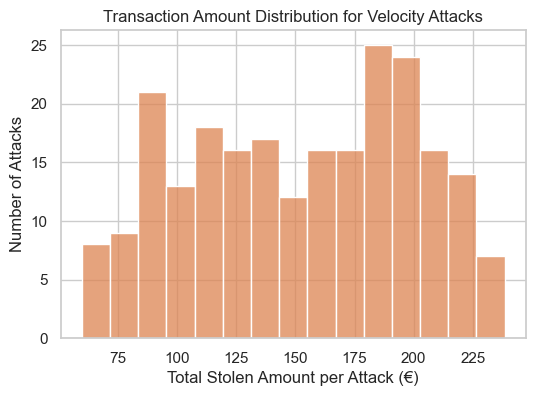

count       232.000000
mean        152.343405
median      155.540000
std          47.254509
min          59.780000
max         238.420000
sum       35343.670000
Name: Total_Stolen, dtype: float64


In [62]:
# Visualize the distribution of transaction amounts only for Velocity attacks grouped
fig, ax_vel = plt.subplots(figsize=(6, 4))

sns.histplot(data=attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity'], x='Total_Stolen', bins=15, kde=False, color='#dd8452', ax=ax_vel)
ax_vel.set_title('Transaction Amount Distribution for Velocity Attacks')
ax_vel.set_xlabel('Total Stolen Amount per Attack (€)')
ax_vel.set_ylabel('Number of Attacks')

plt.show()

amount_vel = attacks_collapsed[attacks_collapsed['Attack_Type'] == 'Velocity']['Total_Stolen'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'sum'])
print(amount_vel)

The total amount stolen in Velocity attacks is significantly lower than in Magnitude fraud. Based on the simulation logic (aggregating multiple random transactions), we expected the distribution to show a central peak (following the Central Limit Theorem). However, the observed pattern appears more uniform, suggesting a high variance in the number of attempts and amount per attack.

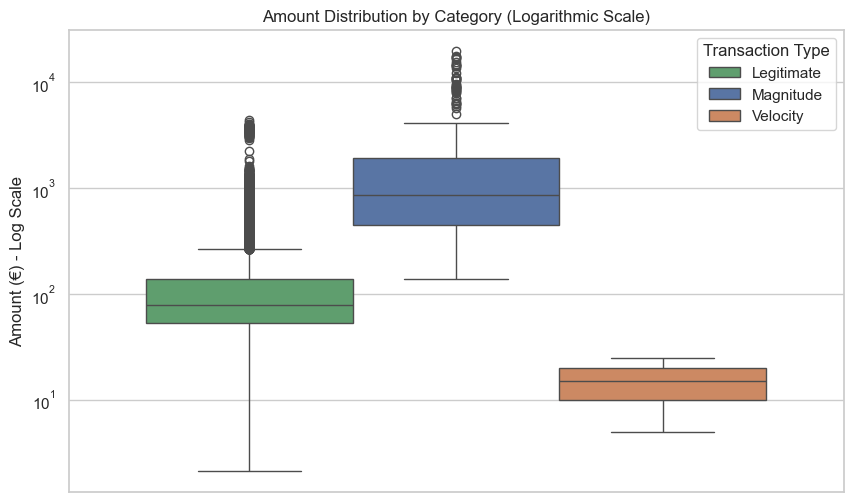

            count         mean   median          std     min       max  \
TXN_Type                                                                 
Legitimate  36608   176.136519   78.600   262.188310    2.12   4355.59   
Magnitude     268  2544.114776  854.985  4021.678669  139.11  19661.54   
Velocity     2353    15.020684   15.120     5.832295    5.00     24.99   

                   sum  
TXN_Type                
Legitimate  6448005.69  
Magnitude    681822.76  
Velocity      35343.67  


In [63]:
# Plotting the distribution of transaction amounts by transaction type

fig, ax_amount = plt.subplots(figsize=(10, 6))

sns.boxplot(
        y='Amount', data=df, hue='TXN_Type', 
        palette={'Legitimate': '#55a868', 'Velocity': '#dd8452', 'Magnitude': '#4c72b0'},
        ax = ax_amount
    )
ax_amount.set_title('Amount Distribution by Category (Logarithmic Scale)')
ax_amount.set_yscale('log') # Logarithmic scale to handle large variance in amounts
ax_amount.set_ylabel('Amount (€) - Log Scale')
ax_amount.legend(title='Transaction Type')

plt.show()

# Cross table analysis between Amount statistics and Transaction Type

amount_type_stats = df.groupby('TXN_Type', observed=True)['Amount'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'sum'])

print(amount_type_stats)

* Velocity Fraud: Concentrated tightly at the bottom of the scale (approx. 5€ - 25€).

* Legitimate Traffic: Spans a wide range (from 2€ coffees to 1,500€ rent/travel and outliers reaching 4355€), representing the natural diversity of human spending.


* Magnitude Fraud: Situated at the extreme top. The mean transaction is 2544€ but the median is 854€ (meaning the majority of the volume is under 2500€) with a high standard deviation and a maximum of 19551€. This points in the direction of the Log-Normal (fat right tail) logic we used to generate the transaction. The gap between the upper whisker of Legitimate transactions and the Magnitude box confirms that these attacks are aggressive "cash-out" attempts that break the user's historical profile.

Note that Legitimate spending overlaps Velocity fraud. This is the challenge for the ML model: distinguishing a 20€ Legitimate lunch from a 20€ Velocity test based on other features (like Time or Location).

### 2.5. Foreign Transactions and Fraud

This analysis compares the transaction location against the customer's registered home city. The results highlight a critical risk indicator: Location Mismatch.

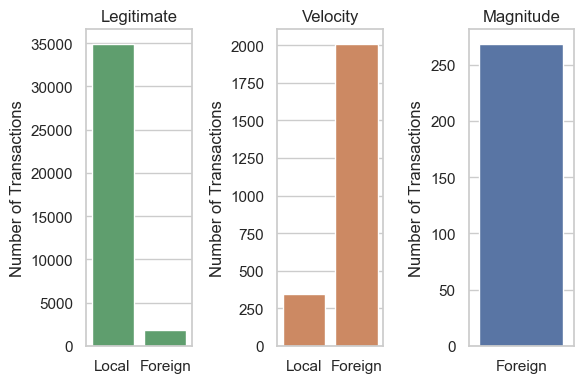

Location Type Counts:
Is_Foreign  Foreign  Local    All
TXN_Type                         
Legitimate     1777  34831  36608
Magnitude       268      0    268
Velocity       2005    348   2353
All            4050  35179  39229

Location Type Rate (%):
Is_Foreign    Foreign     Local
TXN_Type                       
Legitimate    4.85413  95.14587
Magnitude   100.00000   0.00000
Velocity     85.21037  14.78963


In [64]:
# Location analysis of fraud transactions vs legitimate transactions

df['Is_Foreign'] = df.apply(lambda x: 'Foreign' if x['Customer_Home'] != x['Location'] else 'Local', axis=1)

palette_txn={'Legitimate': '#55a868', 'Velocity': '#dd8452', 'Magnitude': '#4c72b0'}

fig, ax_loc = plt.subplots(1,3,figsize=(6, 4))

for ax, tx_type in zip(ax_loc, ['Legitimate', 'Velocity', 'Magnitude']):
    sns.countplot(x='Is_Foreign', data=df[df['TXN_Type'] == tx_type], ax = ax, color=palette_txn[tx_type])
    ax.set_title(tx_type)
    ax.set_ylabel('Number of Transactions')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# Cross table analysis between Location and Transaction Type

location_type_counts = pd.crosstab(df['TXN_Type'], df['Is_Foreign'], margins=True)
print("Location Type Counts:")
print(location_type_counts)

location_type_rate = pd.crosstab(df['TXN_Type'], df['Is_Foreign'], normalize='index') * 100
print("\nLocation Type Rate (%):")
print(location_type_rate)

Legitimate Behavior: The vast majority of legitimate transactions occur within the customer's home city, reflecting routine daily life. The small percentage of "foreign" legitimate transactions represents domestic travel or holidays.

Fraudulent Behavior: A disproportionately high percentage of fraud occurs in locations different from the customer's home.
- Velocity Attacks: These are often anchored to a specific vulnerable merchant (e.g., a terminal in Madrid). For any victim living outside Madrid, these appear as a sudden burst of "foreign" transactions.
- Magnitude Fraud: These attacks deliberately target international or distant locations to complicate traceability and recovery.

The binary feature `Is_Foreign` serves as a strong initial filter for risk.

### 2.6. Transaction Category Analysis

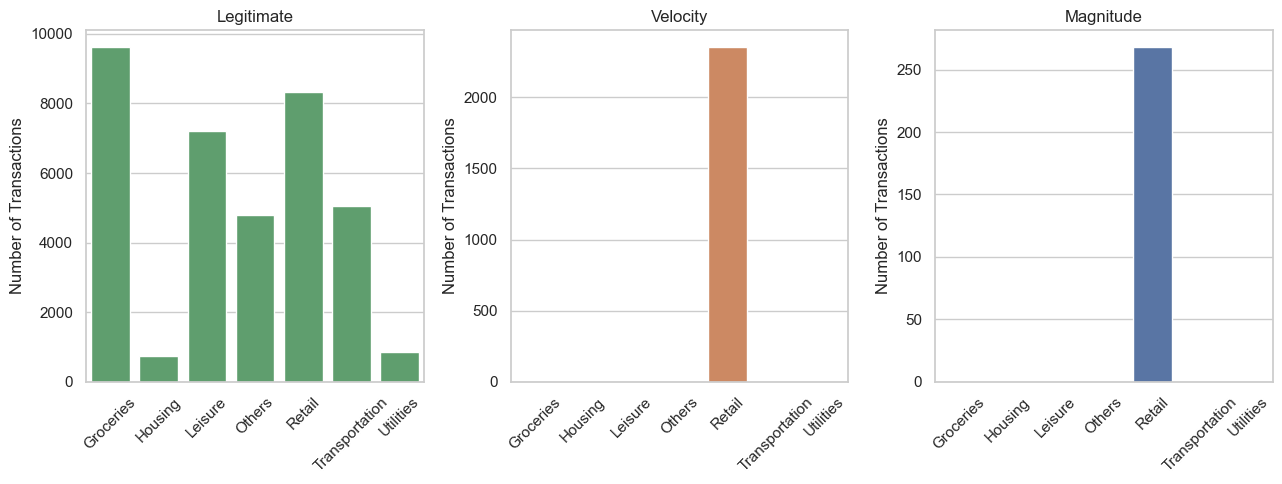

Category Type Counts:
Category    Groceries  Housing  Leisure  Others  Retail  Transportation  \
TXN_Type                                                                  
Legitimate       9620      751     7197    4803    8317            5063   
Magnitude           0        0        0       0     268               0   
Velocity            0        0        0       0    2353               0   
All              9620      751     7197    4803   10938            5063   

Category    Utilities    All  
TXN_Type                      
Legitimate        857  36608  
Magnitude           0    268  
Velocity            0   2353  
All               857  39229  

Category Type Rate (%):
Category    Groceries   Housing    Leisure     Others      Retail  \
TXN_Type                                                            
Legitimate  26.278409  2.051464  19.659637  13.120083   22.719078   
Magnitude    0.000000  0.000000   0.000000   0.000000  100.000000   
Velocity     0.000000  0.000000   0.0000

In [65]:
# Fraud analysis by Category

fig, ax_cat = plt.subplots(1,3,figsize=(13, 5))

for ax, tx_type in zip(ax_cat, ['Legitimate', 'Velocity', 'Magnitude']):
    sns.countplot(x='Category', data=df[df['TXN_Type'] == tx_type], ax = ax, color=palette_txn[tx_type])
    ax.set_title(tx_type)
    ax.set_ylabel('Number of Transactions')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
plt.tight_layout()

os.makedirs('../images', exist_ok=True)
plt.savefig('../images/category_count.png', dpi=300, bbox_inches='tight')

plt.show()

# Cross table analysis between TXN_Type and Category

category_type_counts = pd.crosstab(df['TXN_Type'], df['Category'], margins=True)
print("Category Type Counts:")
print(category_type_counts)

category_type_rate = pd.crosstab(df['TXN_Type'], df['Category'], normalize='index') * 100
print("\nCategory Type Rate (%):")
print(category_type_rate)

This shows a clear simulation weak point, all fraud transactions fall under the Retail category. 

The variable Category is highly predictive. If a transaction is any other than Retail, the probability of fraud drops to zero. Conversely, if the category is Retail, the risk probability increases significantly as it hosts 100% of the attack vectors in this dataset.

Legitimate transactions are well-distributed across all categories, reflecting natural human behavior.

* Groceries (~26%) and Retail (~23%) dominate daily spending.
* Leisure (~20%) and Transportation (~14%) follow.
* Utilities (~2.3%) and Housing (~2.1%) show low transaction counts, which is correct as they are monthly recurrent events, not daily occurrences.


## 3. Profile Behavior and Realism Check

In this section, we analyze transactional behavior disaggregated by customer archetype (Thrifty, Standard, Well-off, Techie).

**Objectives:**
* **Technical Validation:** Confirm that the simulation engine respected the programmed logic (e.g., Techies should show a heavy skew towards Retail).
* **Economic Reality Check:** Critically evaluate the resulting purchasing power and "Wallet Share" of each segment to identify potential over-calibrations or deviations from real-world economic constraints.


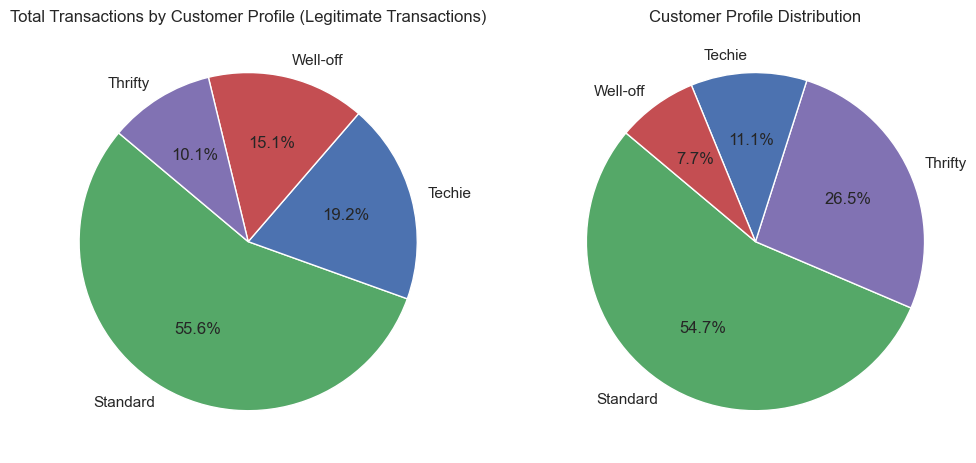

Customer Profile Counts:
Customer_Profile
Standard    547
Thrifty     265
Techie      111
Well-off     77
Name: count, dtype: int64

Total Transactions by Customer Profile (Legitimate Transactions):
Customer_Profile
Standard    20362
Techie       7015
Well-off     5531
Thrifty      3700
Name: count, dtype: int64


In [66]:
# Pie chart of Customer Profile distribution and counts for legitimate transactions only

df_no_unk = df[df['Is_Fraud'] == 0].copy()
df_no_unk['Customer_Profile'] = df_no_unk['Customer_Profile'].cat.remove_categories(['Unknown'])

profile_counts = df_no_unk['Customer_Profile'].value_counts()
fig, ax_pie = plt.subplots(1,2,figsize=(12, 8))

ax_pie[0].pie(profile_counts, labels=profile_counts.index, autopct='%1.1f%%', startangle=140, colors = ['#55a868', '#4c72b0', '#c44e52', '#8172b3'])
ax_pie[0].set_title('Total Transactions by Customer Profile (Legitimate Transactions)')

customer_counts = df_no_unk.groupby('Customer_ID')['Customer_Profile'].first().value_counts()

ax_pie[1].pie(customer_counts, labels=customer_counts.index, autopct='%1.1f%%', startangle=140, colors = ['#55a868','#8172b3', '#4c72b0', '#c44e52'])
ax_pie[1].set_title('Customer Profile Distribution')

plt.tight_layout
plt.show()

print("Customer Profile Counts:")
print(customer_counts)

print("\nTotal Transactions by Customer Profile (Legitimate Transactions):")
print(profile_counts)

As expected, the Standard profile dominates the dataset (~55% of volume). This aligns with them representing the majority of the population (55%) with a moderate usage frequency.

Although Thrifty customers represent a larger demographic slice (26.5% of population) compared to Techies (11.1%) and Well-off (7.7%), the Techies generate nearly double the transaction volume and the Well-Off nearly 2000 more transactions. This confirms that our `frequency_weight` parameter (1.75 for Techies, 2 for Well-Off and 0.35 for Thrifty) is working correctly. It successfully simulates the reality of digital banking: a small group of hyper-active users generates a disproportionate amount of the data traffic.

From a fraud detection perspective, Thrifty users are low-noise environments. A sudden burst of activity in a Thrifty account is statistically highly significant (a clear anomaly).

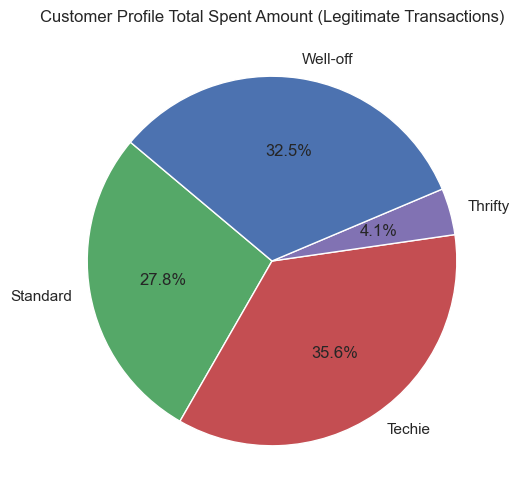

Customer Profile Total Spent Amount (Legitimate Transactions):
Customer_Profile
Standard    1793284.94
Techie      2294305.92
Thrifty      263116.13
Well-off    2097298.70
Name: Amount, dtype: float64

Customer Profile Spent per Capita:
Customer_Profile
Standard     88.070177
Techie      327.057152
Thrifty      71.112468
Well-off    379.189785
dtype: float64


In [67]:
# Pie chart of Customer Profile total spent Amount

profile_total_spent = df_no_unk.groupby('Customer_Profile', observed=True)['Amount'].sum()
fig, ax_pie = plt.subplots(figsize=(6, 6))

ax_pie.pie(profile_total_spent, labels=profile_total_spent.index, autopct='%1.1f%%', startangle=140, colors = ['#55a868',  '#c44e52', '#8172b3', '#4c72b0'])
ax_pie.set_title('Customer Profile Total Spent Amount (Legitimate Transactions)')
plt.show()

print("Customer Profile Total Spent Amount (Legitimate Transactions):")
print(profile_total_spent)

print("\nCustomer Profile Spent per Capita:")
print(profile_total_spent / profile_counts)

We see a sharp stratification in purchasing power.

* Well-off: 379€ per transaction.
* Techie: 327€ per transaction.
* Standard: 88€ per transaction.
* Thrifty: 71€ per transaction.

This confirms that the Log-Normal parameters ($\mu, \sigma$) were correctly differentiated . A Well-off client spends on average 4.3x more per transaction than a Standard client. 

The Techie segment represents only 11.1% of the population (111 clients), yet they generated the highest Total Spent Amount (2.29M€), surpassing even the 'Well-off' group. While the Techie profile was intentionally designed with high discretionary spending (gadgets/electronics), the simulation parameters may have been over-calibrated.

How does this relate to fraud detection?

1. **Magnitude Fraud:**

    Because a Thrifty or Standard customer has a lower transaction value, a fraudulent "cash-out" of 2,000€ represents a much larger deviation from their mean than from a Well-Off or Techie profile.

2. **Velocity Fraud:**

    While Techies and Well-Off generate more frequency noise (making it harder to spot a burst of activity), they generate a massive amount mismatch. Velocity bots typically operate with micro-transactions (5€ - 25€), a sudden stream 10€ transactions is inconsistent with their high-value spending behaviour.

We cannot rely on global thresholds. We must create Customer-Relative Features, such as:
* `Amount_vs_Customer_Avg`: (Transaction Amount / Customer Historical Mean)
* `Frequency_vs_Customer_Avg`: (Current Daily Count / Customer Historical Daily Count)

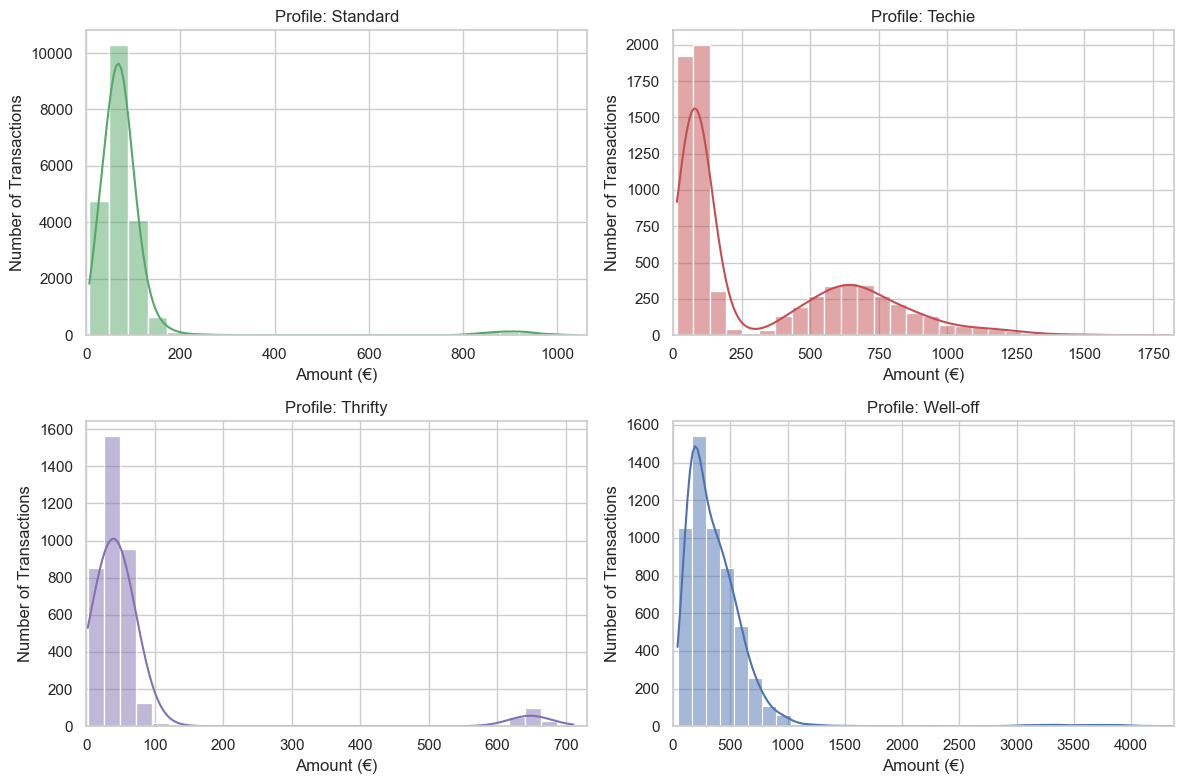

Transaction Amount Statistics by Customer Profile (Legitimate Transactions):
                  count        mean   median         std    min      max  \
Customer_Profile                                                           
Standard          20362   88.070177   69.355  122.947691   6.45  1043.05   
Techie             7015  327.057152  111.610  331.753083  14.07  1806.60   
Thrifty            3700   71.112468   41.710  135.841718   2.12   711.44   
Well-off           5531  379.189785  306.230  376.023195  39.25  4355.59   

                         sum  
Customer_Profile              
Standard          1793284.94  
Techie            2294305.92  
Thrifty            263116.13  
Well-off          2097298.70  


In [68]:
# Visualize the distribution of transaction amounts by Profile Category

amount_profile_stats = df_no_unk.groupby('Customer_Profile', observed=True)['Amount'].agg(['count', 'mean', 'median', 'std', 'min', 'max', 'sum'])

limits_x_amount = {
    'Standard': amount_profile_stats.loc['Standard', 'max'] + 20,
    'Techie': amount_profile_stats.loc['Techie', 'max'] + 20,   
    'Thrifty': amount_profile_stats.loc['Thrifty', 'max'] + 20,   
    'Well-off': amount_profile_stats.loc['Well-off', 'max'] + 20
}
bins_x = {
    'Standard': 25,
    'Techie':  30,   
    'Thrifty': 30,   
    'Well-off': 35
}
colors_x = {
    'Standard': '#55a868',
    'Techie':  '#c44e52',   
    'Thrifty': '#8172b2',   
    'Well-off': '#4c72b0'
}


fig, axes = plt.subplots(2,2,figsize=(12, 8))

for ax, cat in zip(axes.flatten(), df_no_unk['Customer_Profile'].cat.categories):
    sns.histplot(
            data=df_no_unk[df_no_unk['Customer_Profile'] == cat], 
            x='Amount', 
            bins=bins_x[cat], 
            kde=True, 
            color=colors_x[cat], 
            ax=ax
        )
    profile = cat
    ax.set_xlim(0, limits_x_amount[profile])
    ax.set_title(f'Profile: {profile}')
    ax.set_xlabel('Amount (€)')
    ax.set_ylabel('Number of Transactions')

plt.tight_layout()
plt.show()

print("Transaction Amount Statistics by Customer Profile (Legitimate Transactions):")
print(amount_profile_stats)

The histograms confirm that the transaction amounts for all profiles follow a Log-Normal distribution (asymmetric with a heavy right tail).

However, a closer inspection reveals distinct multi-modal behaviors for specific segments:

* **Thrifty & Standard Profiles (Bimodal):** These distributions display two clear local maxima. The primary peak is located at the lower end of the spending scale (representing high-frequency, low-value transactions like Groceries or Leisure). A secondary, much smaller peak appears further to the right, corresponding to the monthly recurring Housing payments.

* **Well-off Profile (Unimodal Dominance):** In contrast, the Well-off distribution is dominated by a single, broader peak at a higher value range. This suggests that their discretionary spending is high enough to blend seamlessly with their housing costs, effectively smoothing out the "Housing bump" that is so visible in the lower-income profiles.

* **Techie Profile (Hybrid Structure):** This segment exhibits a unique hybrid distribution. Like the lower-income groups, it retains a dominant primary peak for frequent small transactions. However, the secondary peak is notably substantial. This anomaly is driven by aggressive Retail spending (high-end electronics).

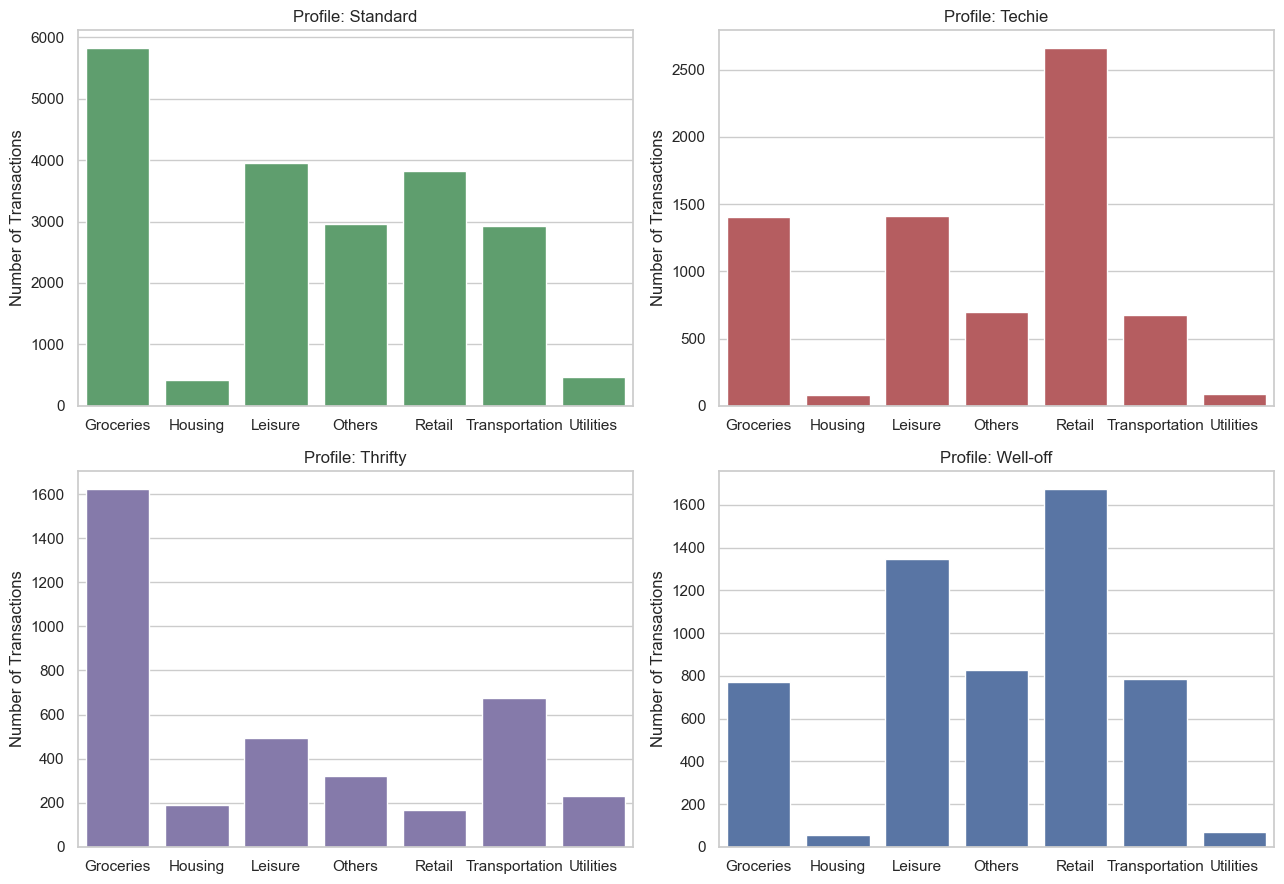

Transaction Category per Profile Counts:
Customer_Profile  Standard  Techie  Thrifty  Well-off    All
Category                                                    
Groceries             5823    1402     1622       773   9620
Housing                425      82      190        54    751
Leisure               3949    1408      494      1346   7197
Others                2956     696      322       829   4803
Retail                3817    2659      168      1673   8317
Transportation        2925     677      674       787   5063
Utilities              467      91      230        69    857
All                  20362    7015     3700      5531  36608

Transaction Category Rate per Profile(%):
Customer_Profile   Standard     Techie    Thrifty   Well-off
Category                                                    
Groceries         28.597387  19.985745  43.837838  13.975773
Housing            2.087221   1.168924   5.135135   0.976315
Leisure           19.393969  20.071276  13.351351  24.335563
O

In [69]:
# Visualize the distribution of transaction Category by Profile
fig, axes = plt.subplots(2,2,figsize=(13, 9))

for ax, cat in zip(axes.flatten(), df_no_unk['Customer_Profile'].cat.categories):
    sns.countplot(
            data=df_no_unk[df_no_unk['Customer_Profile'] == cat], 
            x='Category', 
            color=colors_x[cat], 
            ax=ax
        )
    profile = cat
    ax.set_title(f'Profile: {profile}')
    ax.set_ylabel('Number of Transactions')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

# Cross table analysis between Customer Profile and Category
profile_type_counts = pd.crosstab(df_no_unk['Category'], df_no_unk['Customer_Profile'], margins=True)
print("Transaction Category per Profile Counts:")
print(profile_type_counts)

profile_type_rate = pd.crosstab(df_no_unk['Category'], df_no_unk['Customer_Profile'], normalize='columns') * 100
print("\nTransaction Category Rate per Profile(%):")
print(profile_type_rate)

* **Thrifty:** High concentration in Groceries (43.8%) and Transportation (18.2%), aligning with an essentials-focused lifestyle.

* **Standard:** Balanced spending across Groceries (28.6%), Leisure (19.4%), and *Retail* (18.7%).

* **Well-off:** Disproportionately high spending in Retail (30.2%) and Leisure (24.3%), consistent with a discretionary spending focus.

* **Techie:** Heavily skewed towards Retail (37.9%), validating the profile's affinity for gadgets and technology.

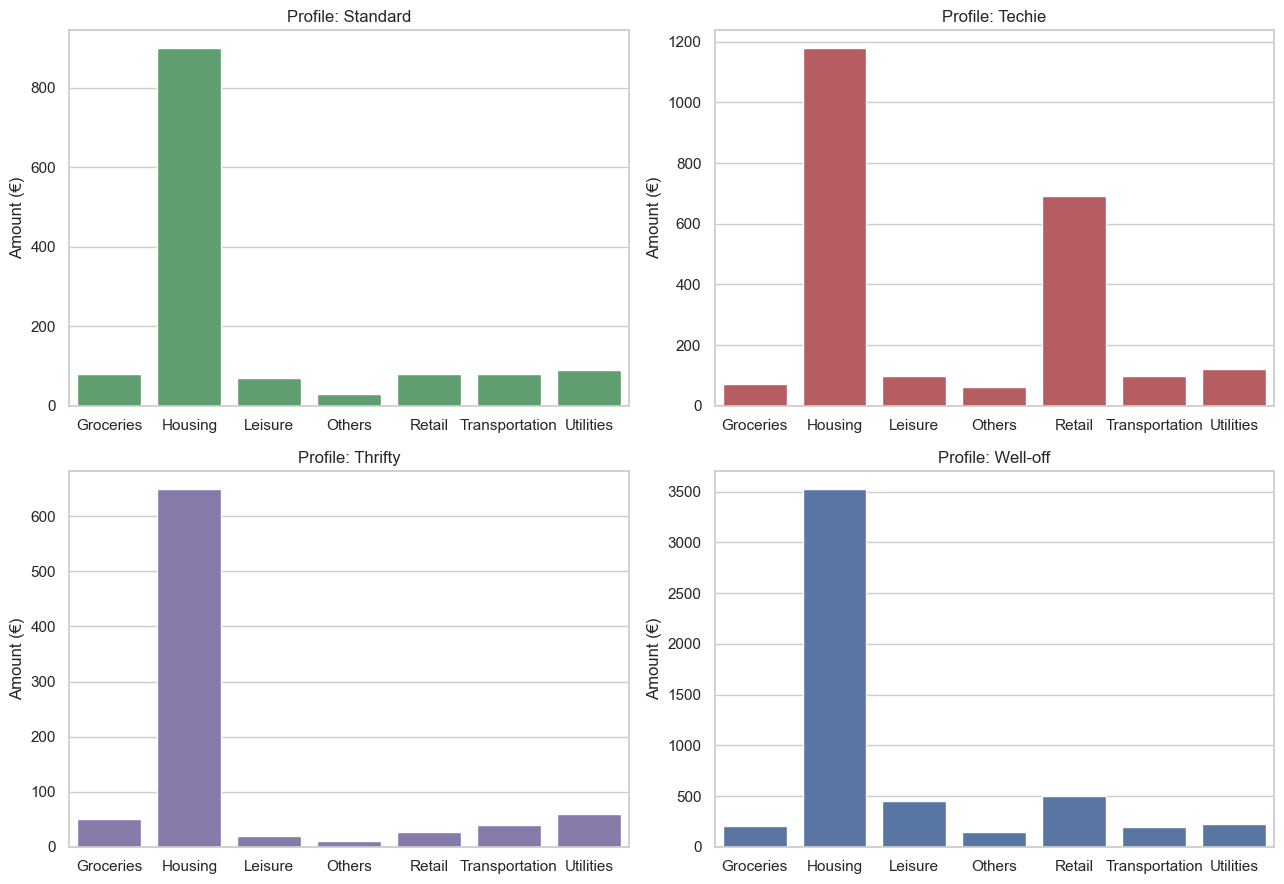

In [70]:
# Visualize the distribution of transaction Category average spent amount by Profile
fig, axes = plt.subplots(2,2,figsize=(13, 9))

for ax, cat in zip(axes.flatten(), df_no_unk['Customer_Profile'].cat.categories):
    sns.barplot(
            data=df_no_unk[df_no_unk['Customer_Profile'] == cat], 
            x='Category',
            y='Amount',
            color=colors_x[cat],
            errorbar=None,
            ax=ax
        )
    profile = cat
    ax.set_title(f'Profile: {profile}')
    ax.set_ylabel('Amount (€)')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

1. **Thrifty Profile**
* Fixed Expenses: They have the lowest fixed costs, with Housing (€650) and Utilities (€60) significantly below the other groups.
* Discretionary: Their discretionary spending is minimal. Retail (€25) and Leisure (€20) are negligible, indicating a lifestyle focused almost entirely on necessities.

2. **Standard Profile**
* Fixed Expenses: Living costs are moderate, with Housing (€900) and Utilities (€90) representing a standard cost of living.
* Discretionary: Spending is evenly distributed across categories. Groceries (€80), Retail (€80), and Transportation (€80) are identical averages, showing no strong skew toward luxury or frugality.

3. **Techie Profile**
* Fixed Expenses: They spend significantly more on living standards than the Standard profile (Housing €1,200), possibly reflecting the need for a home office or a city-center location.
* Discretionary: The standout feature is Retail (€700). This is the highest retail spending of all profiles, surpassing even the 'Well-off' group. Conversely, their spending on Groceries (€70) remains comparable to the Standard profile.

4. **Well-off Profile**
* Fixed Expenses: Dominates the dataset with Housing (€3,500) and Utilities (€220), indicating large properties and high consumption.
* Discretionary: They lead in lifestyle categories, spending €450 on Leisure (fine dining/events) and €200 on Groceries (premium food).

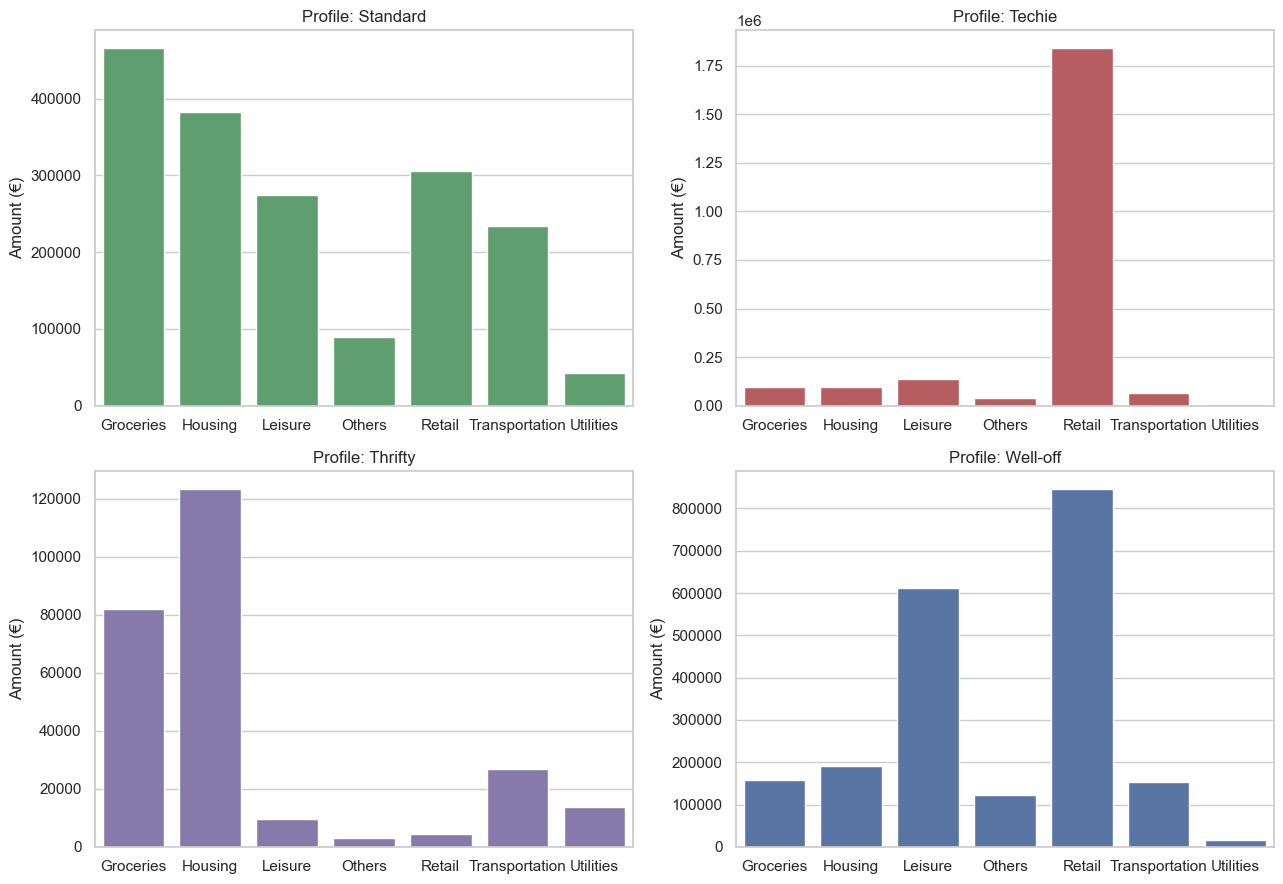

In [71]:
# Visualize the distribution of transaction Category Total Amount spent by Profile
fig, axes = plt.subplots(2,2,figsize=(13, 9))

for ax, cat in zip(axes.flatten(), df_no_unk['Customer_Profile'].cat.categories):
    sns.barplot(
            data=df_no_unk[df_no_unk['Customer_Profile'] == cat], 
            x='Category',
            y='Amount',
            estimator=np.sum,     
            errorbar=None,
            color=colors_x[cat], 
            ax=ax
        )
    profile = cat
    ax.set_title(f'Profile: {profile}')
    ax.set_ylabel('Amount (€)')
    ax.set_xlabel('')

plt.tight_layout()
plt.show()

Analyzing the Total Spending by category reveals a significant deviation from real-world household budget models. While the profiles are statistically distinct, none of them perfectly emulate realistic financial behavior:

1. **Techie**
* This profile spent a staggering €1.84M on Retail, while only spending €96k on Housing.
* This creates a ratio of 19:1 (Retail vs. Rent). In the real world, no demographic spends 19 times more on shopping than on their home. This confirms that our simulation over-indexed the Retail parameters for this group.

2. **Well-off**
* The wealthy segment spent €845k on Retail and €612k on Leisure, vastly outstripping their Housing costs (€190k).
* High-net-worth individuals typically have high fixed asset costs (expensive properties/mortgages). We would expect Housing to be their dominant or co-dominant category, not a minor line item compared to shopping.

3. **Standard**
* Even the baseline profile spends significantly more on Groceries (€465k) than on Housing (€382k).
* This contradicts standard economic data, where housing typically consumes 30-40% of a household's income, with food accounting for 10-15%. Our simulation has inverted this relationship due to the high frequency of daily transactions versus the single monthly nature of fixed expenses.

While these distinct patterns are useful for training a classifier to distinguish profiles, an improved version of this simulation should recalibrate the `lognormal_params` to better align with macroeconomic realities, specifically increasing the weight/amount of Housing to restore it as the primary expense for all groups.

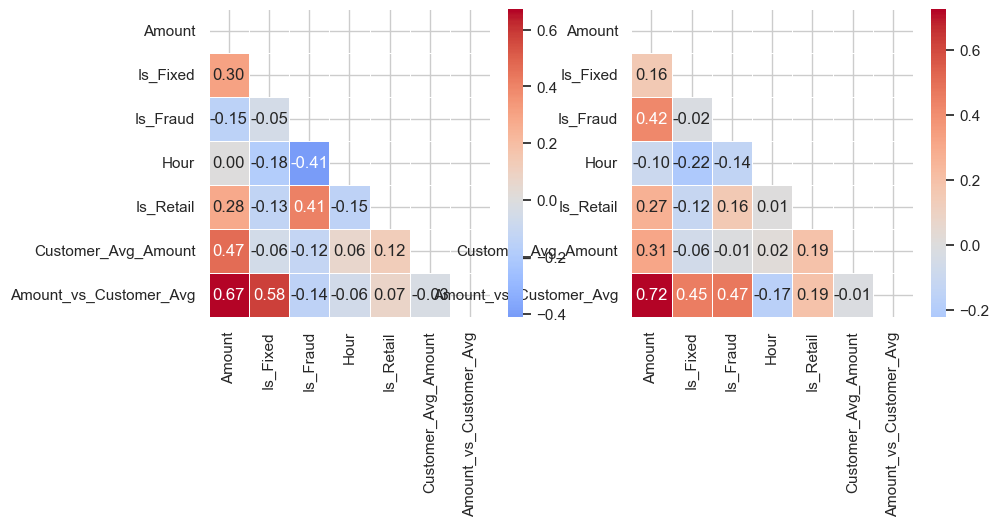

In [72]:
# Initial feature engineering for correlation analysis
df['Is_Retail'] = df['Category'].apply(lambda x: 1 if x in 'Retail' else 0)

df['Customer_Avg_Amount'] = df.groupby('Customer_ID')['Amount'].transform('mean')
df['Amount_vs_Customer_Avg'] = df['Amount'] / df['Customer_Avg_Amount']

# Divide the dataframe for analysis between Velocity and Magnitude attacks
df_velocity = df[df['TXN_Type'] != 'Magnitude']
df_magnitude = df[df['TXN_Type'] != 'Velocity']

# Correlation matrix for Velocity and Magnitude datasets
correlation_matrix_vel = df_velocity.corr(numeric_only=True)
correlation_matrix_mag = df_magnitude.corr(numeric_only=True)

fig , axes = plt.subplots(1,2,figsize=(10,4))

sns.heatmap(
    correlation_matrix_vel,
    annot=True,
    mask=np.triu(np.ones_like(correlation_matrix_vel, dtype=bool)),           
    fmt=".2f",            
    cmap="coolwarm",      
    linewidths=0.5,       
    center=0,           
    ax=axes[0]
)

sns.heatmap(
    correlation_matrix_mag,
    annot=True,
    mask=np.triu(np.ones_like(correlation_matrix_mag, dtype=bool)),           
    fmt=".2f",            
    cmap="coolwarm",      
    linewidths=0.5,       
    center=0,           
    ax=axes[1]
)

plt.show()

**Correlation Analysis: Legitimate vs. Velocity Attacks:**

**Fraud Correlations (`Is_Fraud`):**
* **Moderate/Low Negative Correlation with `Hour` (-0.41):** This confirms the temporal pattern observed earlier, where velocity attacks (the only fraud type in this subset) are concentrated in specific hours (likely overnight), contrasting with legitimate activity.
* **Moderate/Low Positive Correlation with `Is_Retail` (0.41):** This aligns with the finding that all velocity attacks in this dataset target the 'Retail' category.
* **Weak Negative Correlation with Amounts:** `Is_Fraud` has a weak negative correlation with `Amount` (-0.15) and `Amount_vs_Customer_Avg` (-0.14). This reflects the nature of velocity attacks, which typically involve low-value transactions that may not significantly deviate from a customer's average spending amount (especially for Thrifty/Standard profiles).

**Correlation Analysis: Legitimate vs. Magnitude Attacks:**

**Fraud Correlations (`Is_Fraud`):**
* **Moderate/Low Positive Correlation with Amount_vs_Customer_Avg (0.47):** This is the strongest indicator in the dataset. It suggests that Magnitude attacks tend to deviate significantly from the customer's typical spending habits. The positive correlation implies that fraud often involves amounts notably higher than the user's average.
* **Moderate/Low Positive Correlation with Amount (0.42):** Closely related to the point above, there is a clear link between higher absolute transaction values and fraud.
* **Weak Positive Correlation with Is_Retail (0.16):** There is a slight tendency for Magnitude attacks to occur more frequently in retail transactions compared to non-retail ones, though the relationship is not very strong.
* **Weak Negative Correlation with Hour (-0.14):** A weak negative correlation suggests that Magnitude attacks are slightly more likely to happen earlier in the day (lower hour values), or conversely, less likely to happen as the hour increases.


## 4.Final Reflection

Conducting an Exploratory Data Analysis on synthetic data engineered by oneself presents a unique analytical challenge: avoiding **confirmation bias**.

Since the underlying logic (Log-Normal spending distributions, Bimodal active hours, and specific fraud vectors) was explicitly programmed in generate_data.py, there is an inherent temptation to take these patterns for granted. The difficulty lies in analyzing the dataset objectively, letting the statistical evidence speak for itself rather than projecting prior knowledge onto the visualizations.

This exercise has served as a rigorous validation of the simulation engine. By forcing ourselves to "rediscover" the patterns through standard analytical tools (Boxplots, Chi-Squared tests, Aggregations), we have confirmed that the signals are not just theoretical code, but empirically visible features. The data holds up to scrutiny.

We can now proceed to the Model Training phase with confidence, knowing that the exclusive concentration of attacks within the **Retail sector** and the distinct isolation of fraudulent activity during **overnight hours** are robust, learnable features that a Machine Learning algorithm can detect without having access to the source code.